# ANALYZING   AN   ORGANIZATION’S   PERFORMANCE  TO   PREDICT   FUTURE   STOCK    MOVEMENT!

## **PROJECT NAME**
##### *ANALYZING AN ORGANIZATION’S PERFORMANCE TO PREDICT FUTURE STOCK MOVEMENT*

**GROUP DETAILS:** GROUP 1

**TEAM MEMBERS**

| Name                               	| ID       	|
|:------------------------------------	|:---------:|
| Sonam Lakhe                        	| 12010044 	|
| KaliPrasad Raghavendra Kuchibhotla 	| 12010071 	|
| Debjit Ray                         	| 12010066 	|
| Vasudev Maduri                     	| 12010065 	|
| Ravikiran Ravinuthala              	| 12010045 	|

#### Install or Import all external packages required for the program
Install all packages present in Requirements.txt included along with the submission. 

In [1]:
try:
    from twitter_scraper import get_tweets  
except ImportError:
    %pip install twitter_scraper
    from twitter_scraper import get_tweets  

try:
    from selenium import webdriver
except ImportError:
    %pip install selenium
    from selenium import webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.common.exceptions import TimeoutException 
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

try:
    import requests
except ImportError:
    %pip install requests
    import requests
# from datetime import datetime, date
import pandas as pd

try: 
    from bs4 import BeautifulSoup
except ImportError:
    %pip install bs4
    from bs4 import BeautifulSoup
try:
    import requests
except ImportError:
    %pip install requests
    import requests

#### Import the dependencies

In [2]:
import time
import os
import csv
import pandas as pd
from math import ceil  
import datetime
import random
import sys
import utility
import traceback
import logging
import re
import json
import enum

#### Define the different source URL's

In [3]:
class urls(enum.Enum): 
    indeed = "https://www.indeed.co.in/cmp/"
    newsApi = 'https://newsapi.org/v2/everything?q='
    moneyControl = "https://www.moneycontrol.com"
    moneyControlBase = "https://www.moneycontrol.com/stocks/marketstats/sector-classification/"
    yahooFinance = "https://in.finance.yahoo.com/quote/"

#### Class to extract Twitter data
                                                
Below class is defined to extracts the tweets based on the company name passed as input. 
The elements extracted are 
    1. Date and time of the tweet  
    2. Tweet string
    3. Number of likes to the tweeted string
    4. Number of retweets 
    5. Number of Replies to the tweets.
    

##### Method Used - Tweeter scraper package 

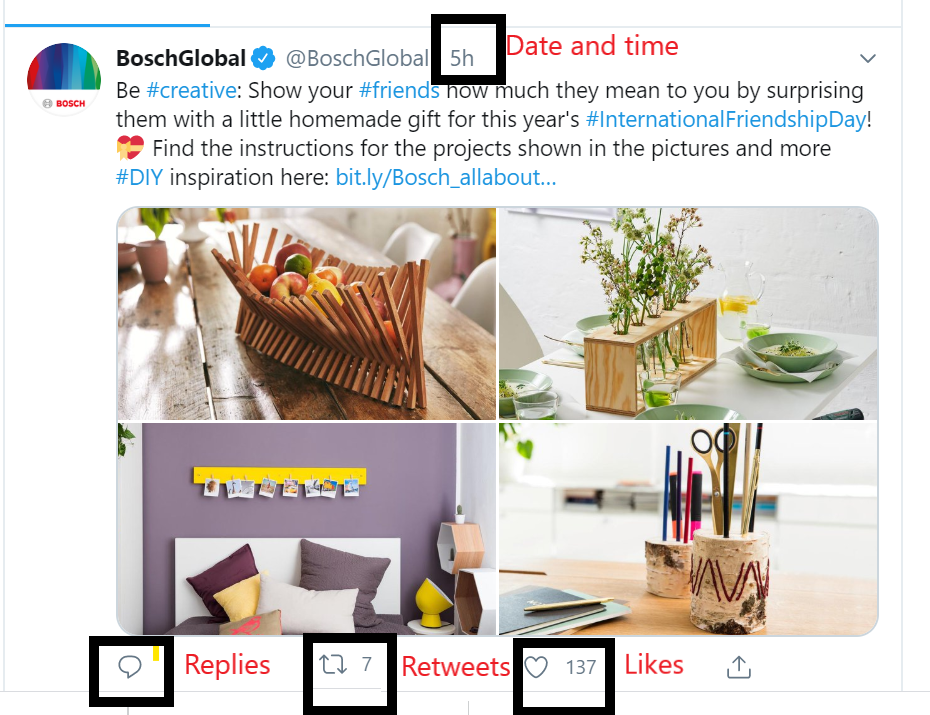

In [4]:
class fetch_tweets:
    
    def get_tweets(self, company):
        
        formated_search_tag = utility.format_search_tag(company)
        twitter_df = pd.DataFrame()
        try:
            print('INFO!! Extracting tweets for ' + company)            
            tweets = get_tweets(formated_search_tag,pages=1)
            for tweet in tweets:
                twitter_data = self.format_tweet_data(tweet)
                if twitter_data is not {}:   
                    twitter_df = twitter_df.append(pd.DataFrame(twitter_data),ignore_index=True)
            if len(twitter_df.columns) > 0: 
                twitter_df = twitter_df.sort_values(by=['DateTime', 'NoofLikes', 'NoofRetweets'], ascending=False)            
        except Exception as e:
            logging.error(traceback.format_exc())  
        return twitter_df
      
            
    @staticmethod
    def format_tweet_data(tweet):
        is_a_retweet = tweet['isRetweet']
        twitter_data = {}
        if is_a_retweet == False:
            tweet_text = tweet['text']
            tweet_date_time = tweet['time'].strftime("%Y/%m/%d.%H:%M:%S")
            tweet_likes_count = tweet['likes']
            tweet_retweet_count = tweet['retweets']
            tweet_replies_count = tweet['replies']
            
            twitter_data = {'DateTime':[tweet_date_time],
                    'Text':[tweet_text],
                    'NoofLikes':[tweet_likes_count],
                    'NoofRetweets':[tweet_retweet_count],
                    'NoofReplies':[tweet_replies_count]
                   }
        return twitter_data    

#### Class to extract Employee Reviews from Indeed
            
Below class is used to extract the Employee Reviews based on company passed as input
Following delatils as part of review are obtained 
    1. Designation of the reviewer
    2. Overall Rating as per the reviewer
    3. Review String
    4. Pros 
    5. Cons
    
##### Method Used - Selenium screen scraping 

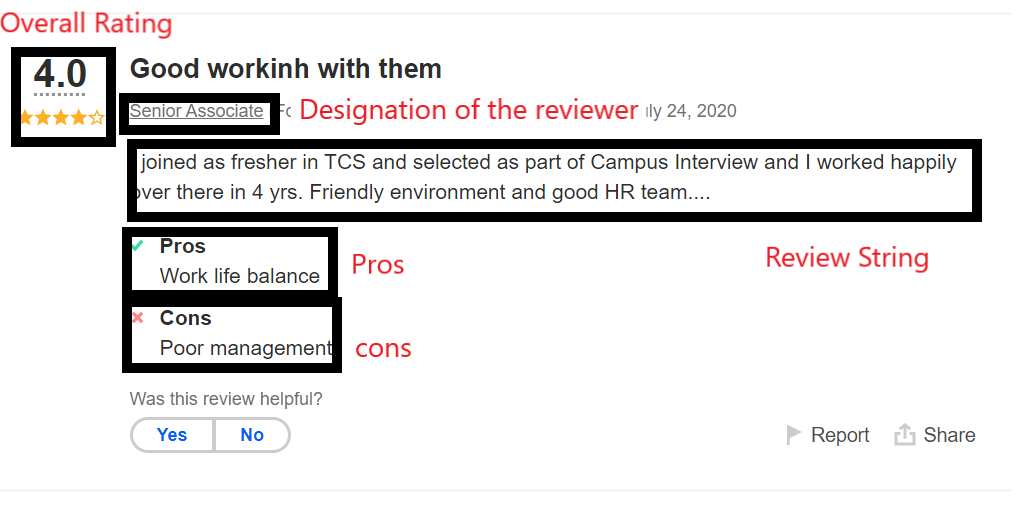


In [5]:
class emp_review():
    def fetch_emp_review(self,company):
        n = 0
        indeed_df = pd.DataFrame()
        
        page = urls.indeed.value + company.replace(" ", "%20") + "/reviews"
        request = requests.get(page)
        if request.status_code == 200:
            print('INFO!! Extracting employee reviews for ' + company)
        else:
            print('INFO!! Web site does not exist for ' + company + ". URL tried - " + page) 
            return indeed_df
        
        driver = utility.get_driver(webdriver)
        driver.get(page)
        try:
            company = page
            n = n+1
            # Iterate through pages to capture 1st 100 reviews
            index = 0

            try:
                reviewsNumbers = driver.find_elements_by_xpath('//div[@class = "cmp-NavMenu-innerContainer"]')
                for number1 in reviewsNumbers:
                    numberOfReviewsStr1 = number1.find_element_by_xpath('.//div[@class = "cmp-CompactHeaderMenuItem-count"]').text
            except:
                numberOfReviewsStr1 = "0"

            numberOfReviewsStr1 = numberOfReviewsStr1.replace(',', '')
            numberOfReviews = int(numberOfReviewsStr1)
            num1 = int(numberOfReviews / 20)
            if (num1 - 1) * 20 < 80:
                check = num1 * 20
            else:
                check = 80;

            while index <= check:
                driver.get(page + "?start=" + str(index))
                time.sleep(random.randint(5,15))

                try:
                    index = index + 20

                    # Find all the reviews:
                    reviews = driver.find_elements_by_xpath('//div[@class = "cmp-Review"]')
                    for review in reviews:
                        # Initialize an empty dictionary for each review
                        review_dict = {}

                        try:
                            Designation = review.find_element_by_xpath(
                                './/a[@class = "cmp-ReviewAuthor-link"]').text
                        except:
                            Designation = ""
                        try:
                            Rating = review.find_element_by_xpath(
                                 './/div[@class = "cmp-ReviewRating-text"]').text
                        except:
                            Rating = ""
                        try:
                            Customer_review = review.find_element_by_xpath(
                                './/div[@class = "cmp-Review-title"]').text
                        except:
                            Customer_review = ""
                        try:
                            Pros = review.find_element_by_xpath(
                                 './/div[@class = "cmp-ReviewProsCons-prosText"]//span[@class = "cmp-NewLineToBr"]//span[@class = "cmp-NewLineToBr-text"]').text
                        except:
                            Pros = ""
                        try:
                            Cons = review.find_element_by_xpath(
                                 './/div[@class = "cmp-ReviewProsCons-consText"]//span[@class = "cmp-NewLineToBr"]//span[@class = "cmp-NewLineToBr-text"]').text
                        except:
                            Cons = ""

                        review_dict['Company'] = company
                        review_dict['Designation'] = Designation
                        review_dict['Rating'] = Rating
                        review_dict['Customer_review'] = Customer_review
                        review_dict['Pros'] = Pros
                        review_dict['Cons'] = Cons

                        indeed_df = indeed_df.append([review_dict],ignore_index=True)

                except Exception as excp:
                    print("\n Exception occurred: " + excp)

        except Exception as excp:
            print("\n Exception occurred: " + excp)

        driver.quit()
        return indeed_df

#### Class to extract relevant news from newsaPI
                                                
Below class is defined to captures News articles from newsapi.org website based on the company name passed as input. 

The details include Articles and are sorted based on 
    1. Relevancy 
    2. Popularity 
    3. and Published at (Source of the news)
    
##### Method Used - Consumption of newapi REST APi service   


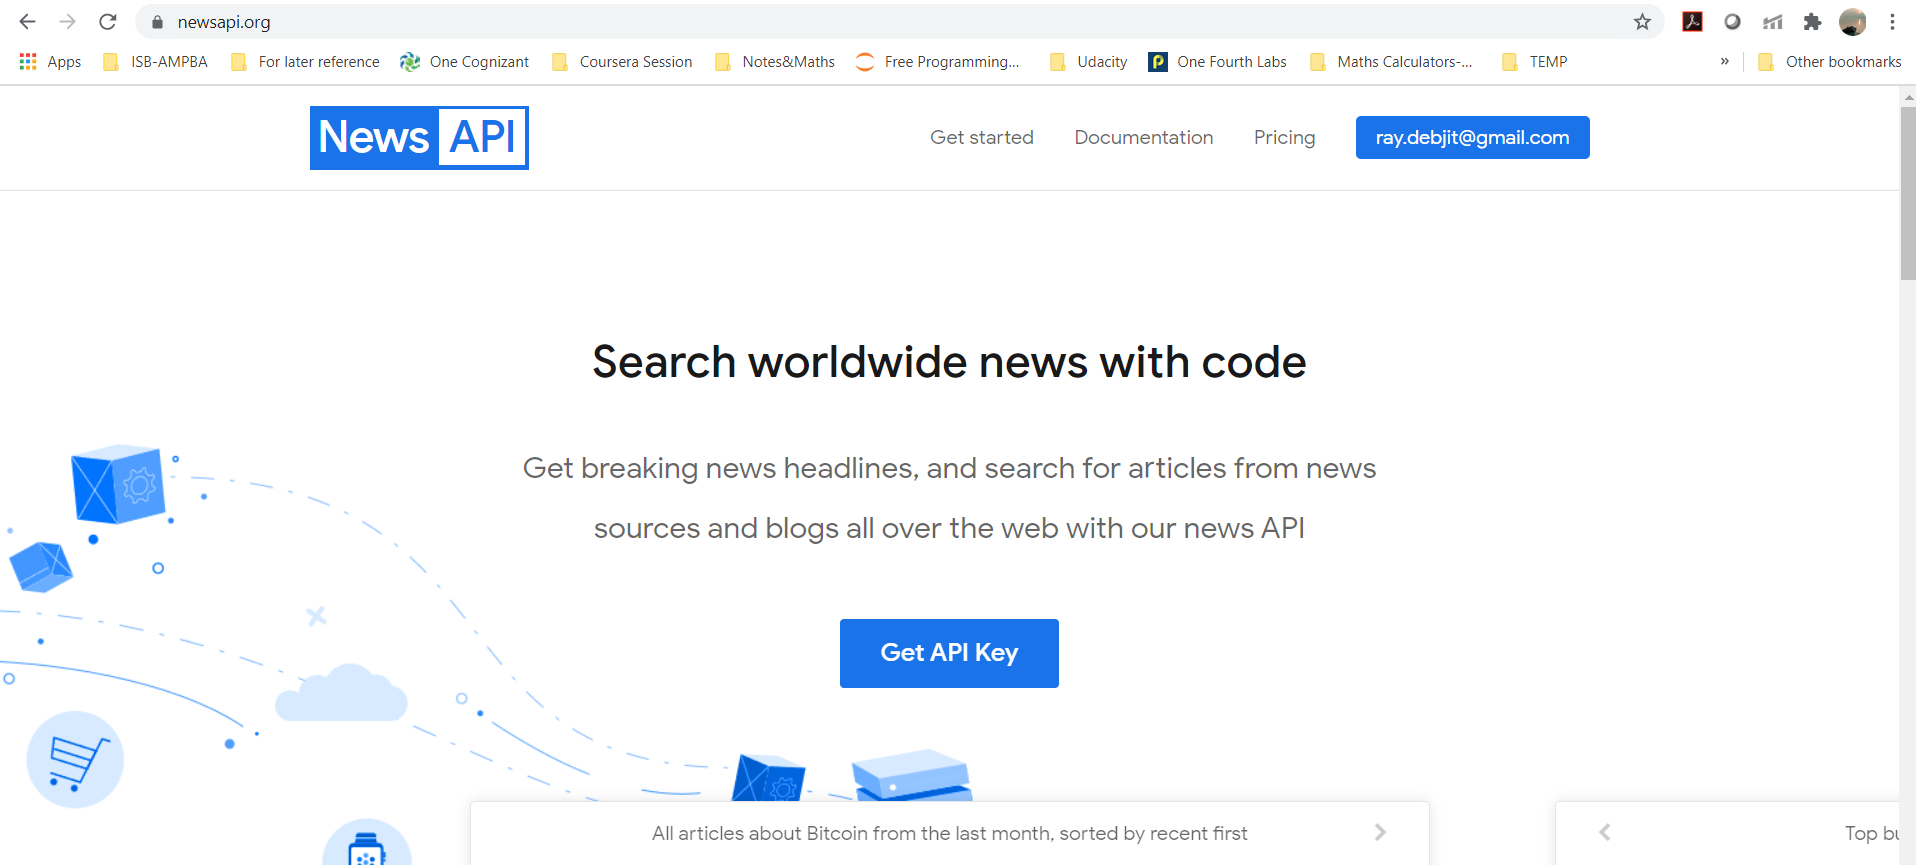

In [6]:
class news_bytes():
    def fetch_news(self,
                   org, 
                   startDate, 
                   endDate,
                   api_key ='2d316a0ecc7e47768d88bc7201652b33', 
                   sortByIdx = 0):
        print('INFO!! Extracting news for ' + org)
        sortBy = ["relevancy","popularity","publishedAt"]
        url = urls.newsApi.value +org+'&from='+startDate+'&to='+endDate+'&sortBy='+sortBy[sortByIdx]+'&apiKey='+ api_key
        response = requests.get(url)
        newsObj = json.loads(response.text)
        newsObj = newsObj['articles']
        dfNews = pd.DataFrame.from_dict(newsObj)
        for index, row in dfNews.iterrows(): 
            row['source'] = row['source']['name']
  
        return dfNews

#### Class to extract historical price of the stock 
                                                
Below class is defined to extracts the trade details of a stock based on the company name passed as input. 
The details extracted are
    1. Opening Price
    2. High
    3. Low 
    4. Closing price
    5. Adiusted closing price 
    6. Volume of the transaction    

##### Method Used - Selenium screen scraping 
    

###### First,  search for the stock to uniquely identify the stock in its correspoding exchange. On the webpage, the corresponding API call is as shown below.

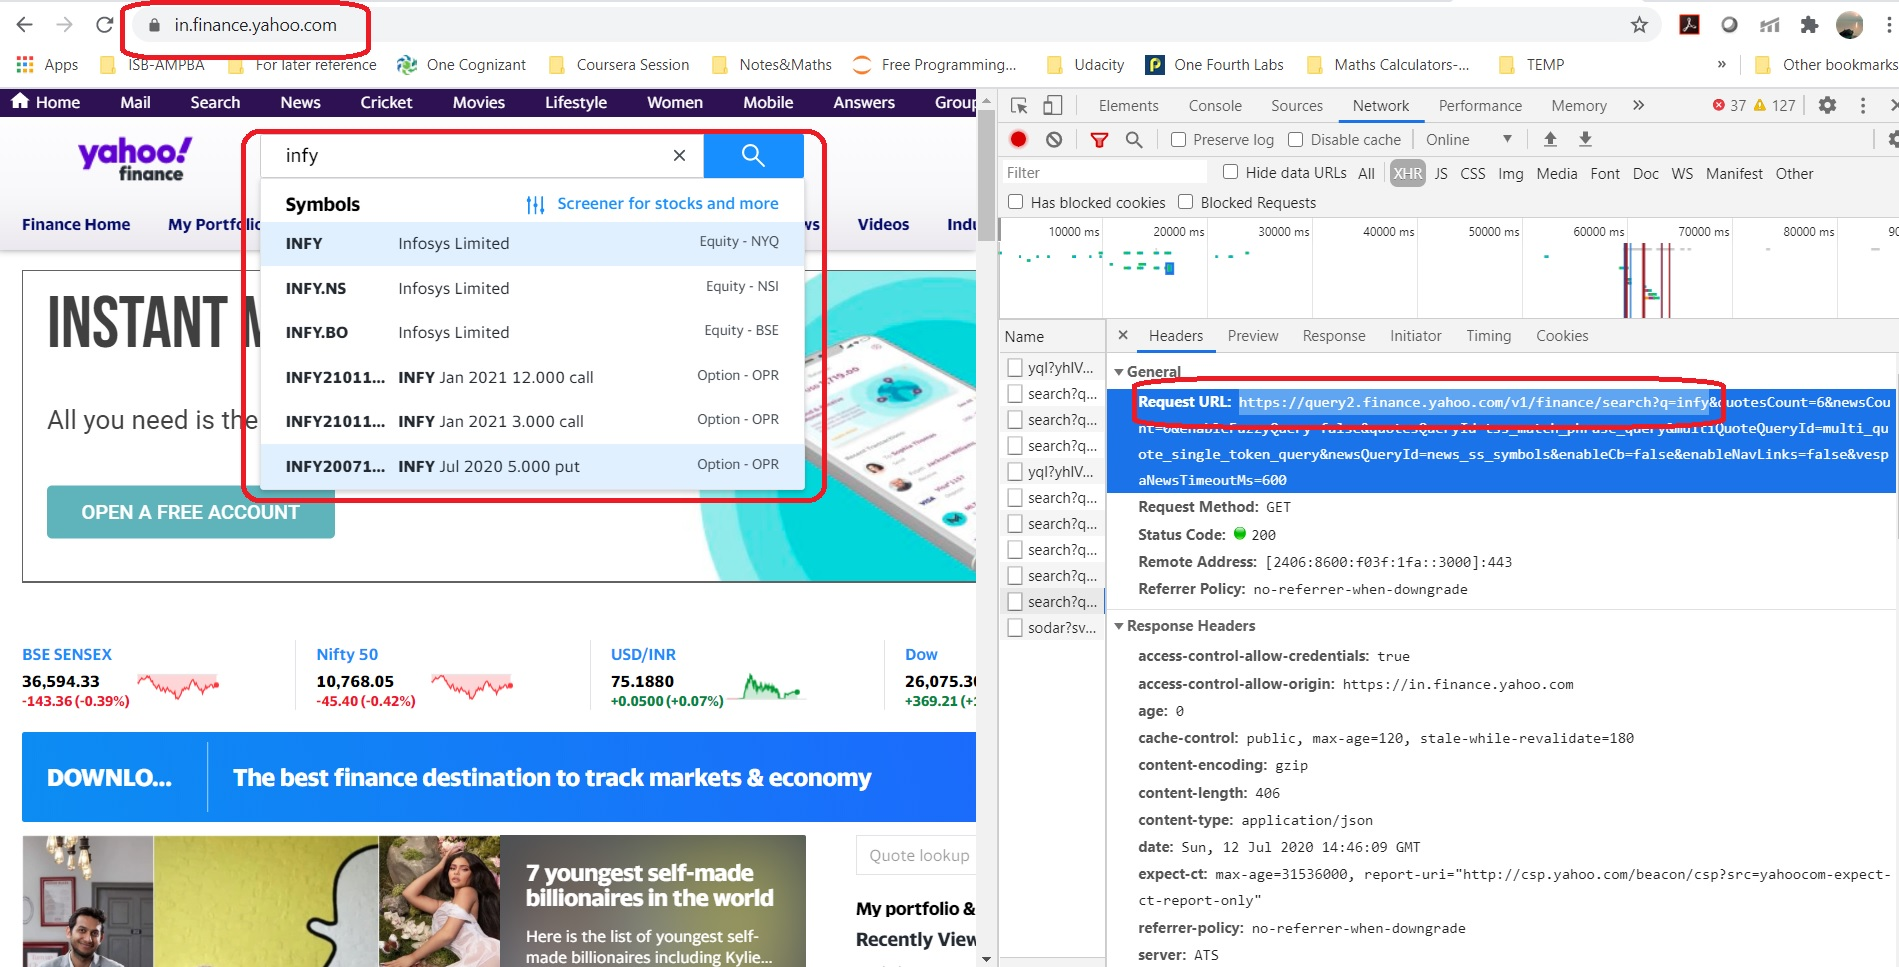

###### The response for the above API comes in the below format i.e. quotes is a list of dictionaries. Each dictionary identifies a matching stock in a specific exchange.

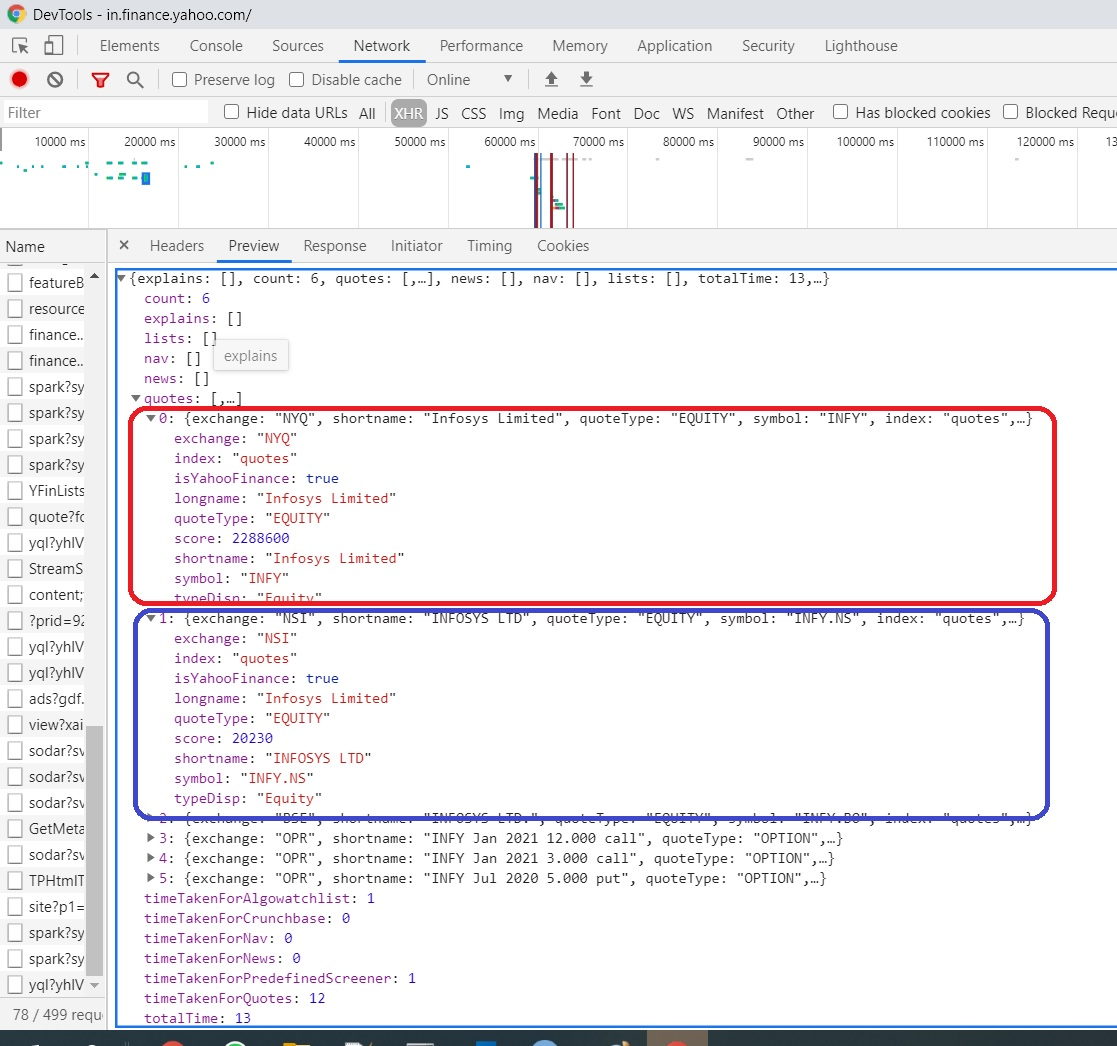

###### Though the API on the UI invokes with a lot of additional query string parameters. We will keep it simple by just hitting the specific API as below.

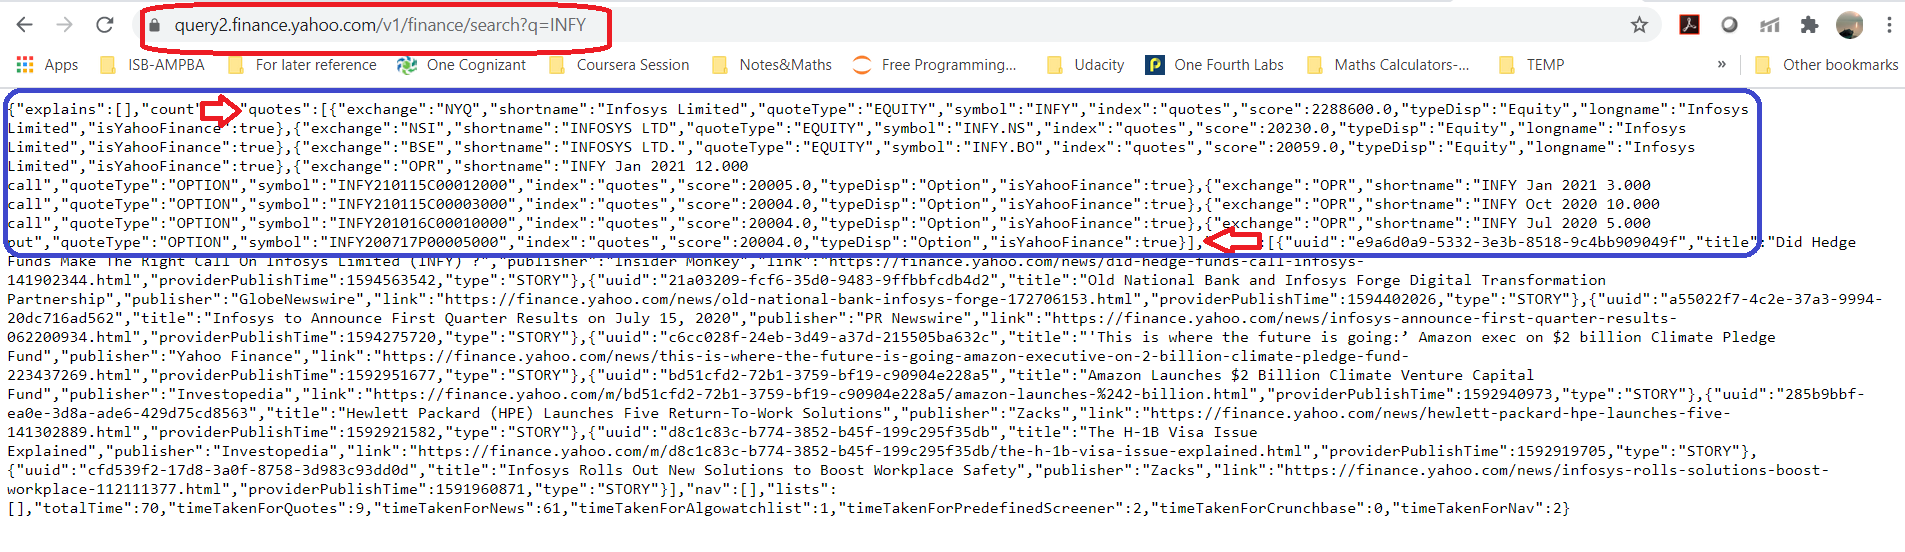

###### Once we have identified the specific stock in the corresponding exchange, we will use the corresponding symbol to form the corresponding URL for historical price search.

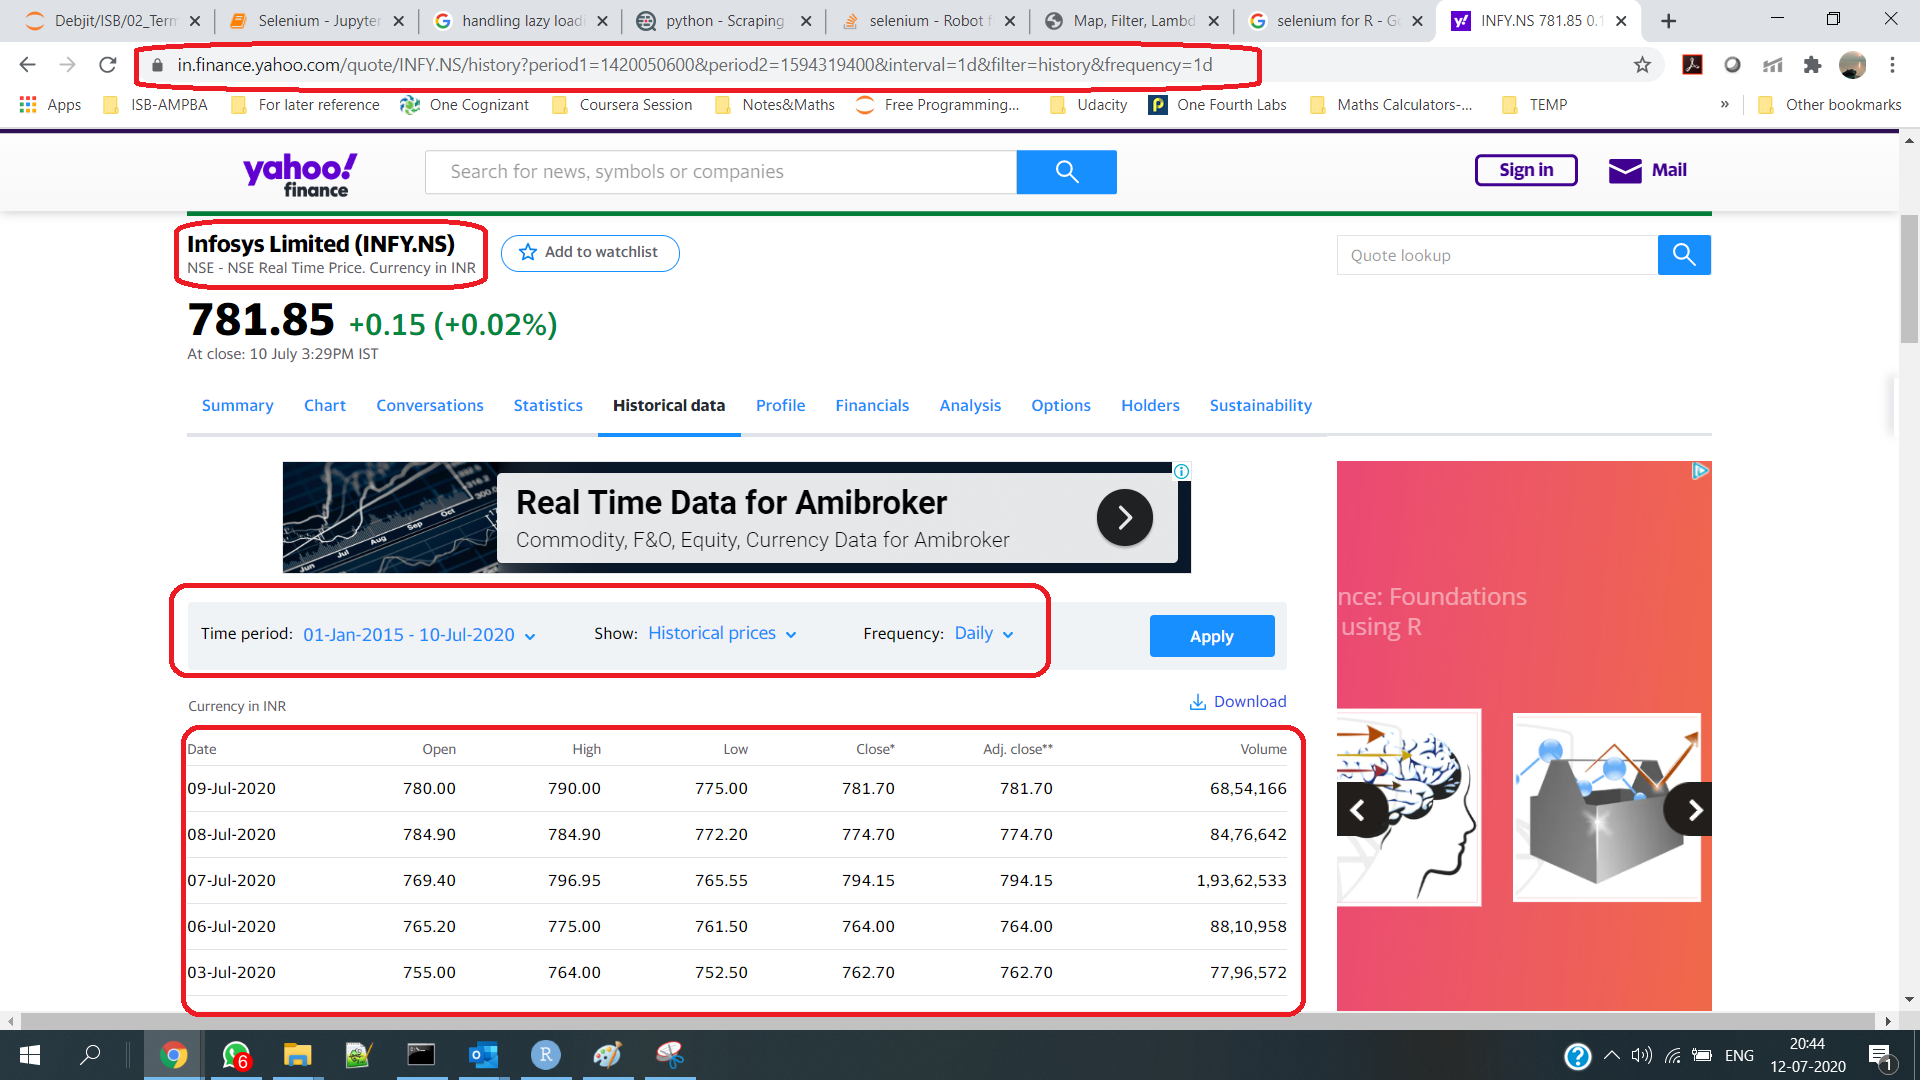

###### Now, we identify the tags for the different elements which we will be scraping. First thing, we will be scraping is the Stock Name and its corresponding symbol.

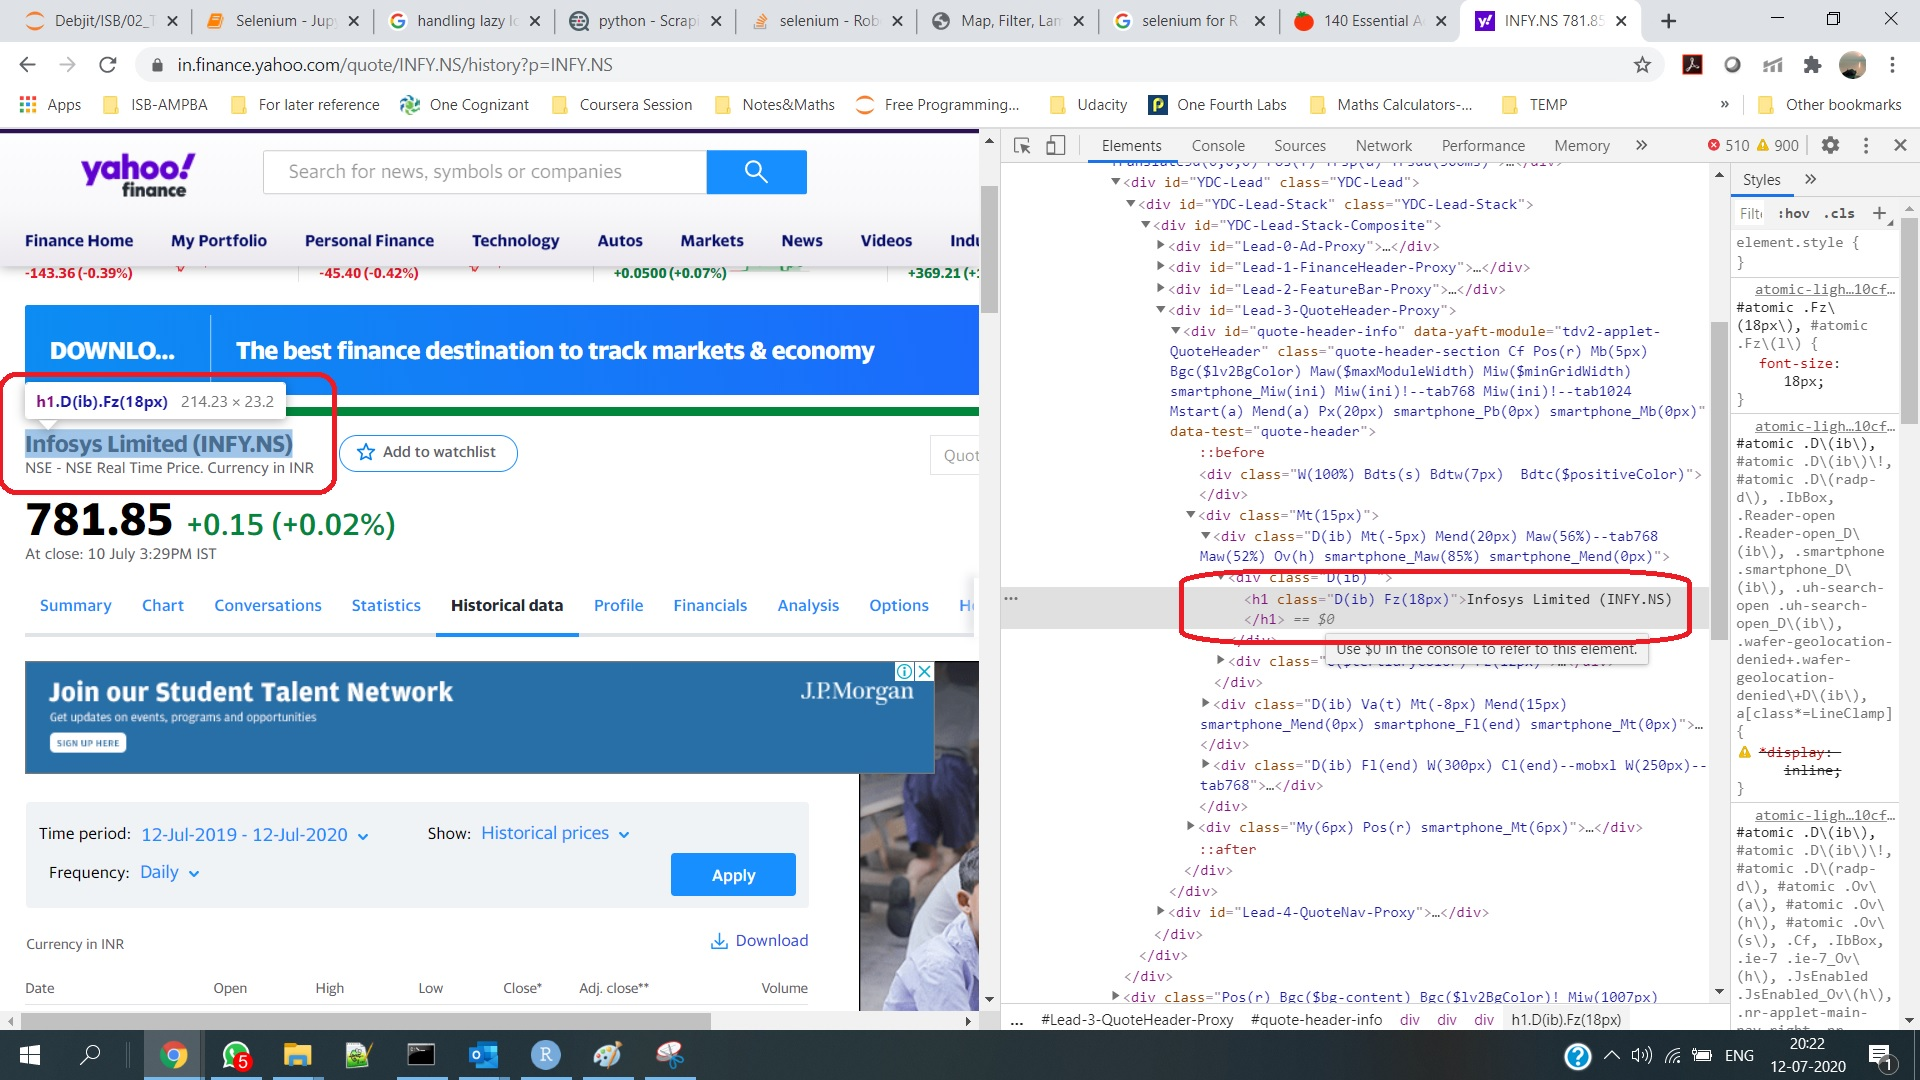

###### Next, we scrape the table header for the column names.

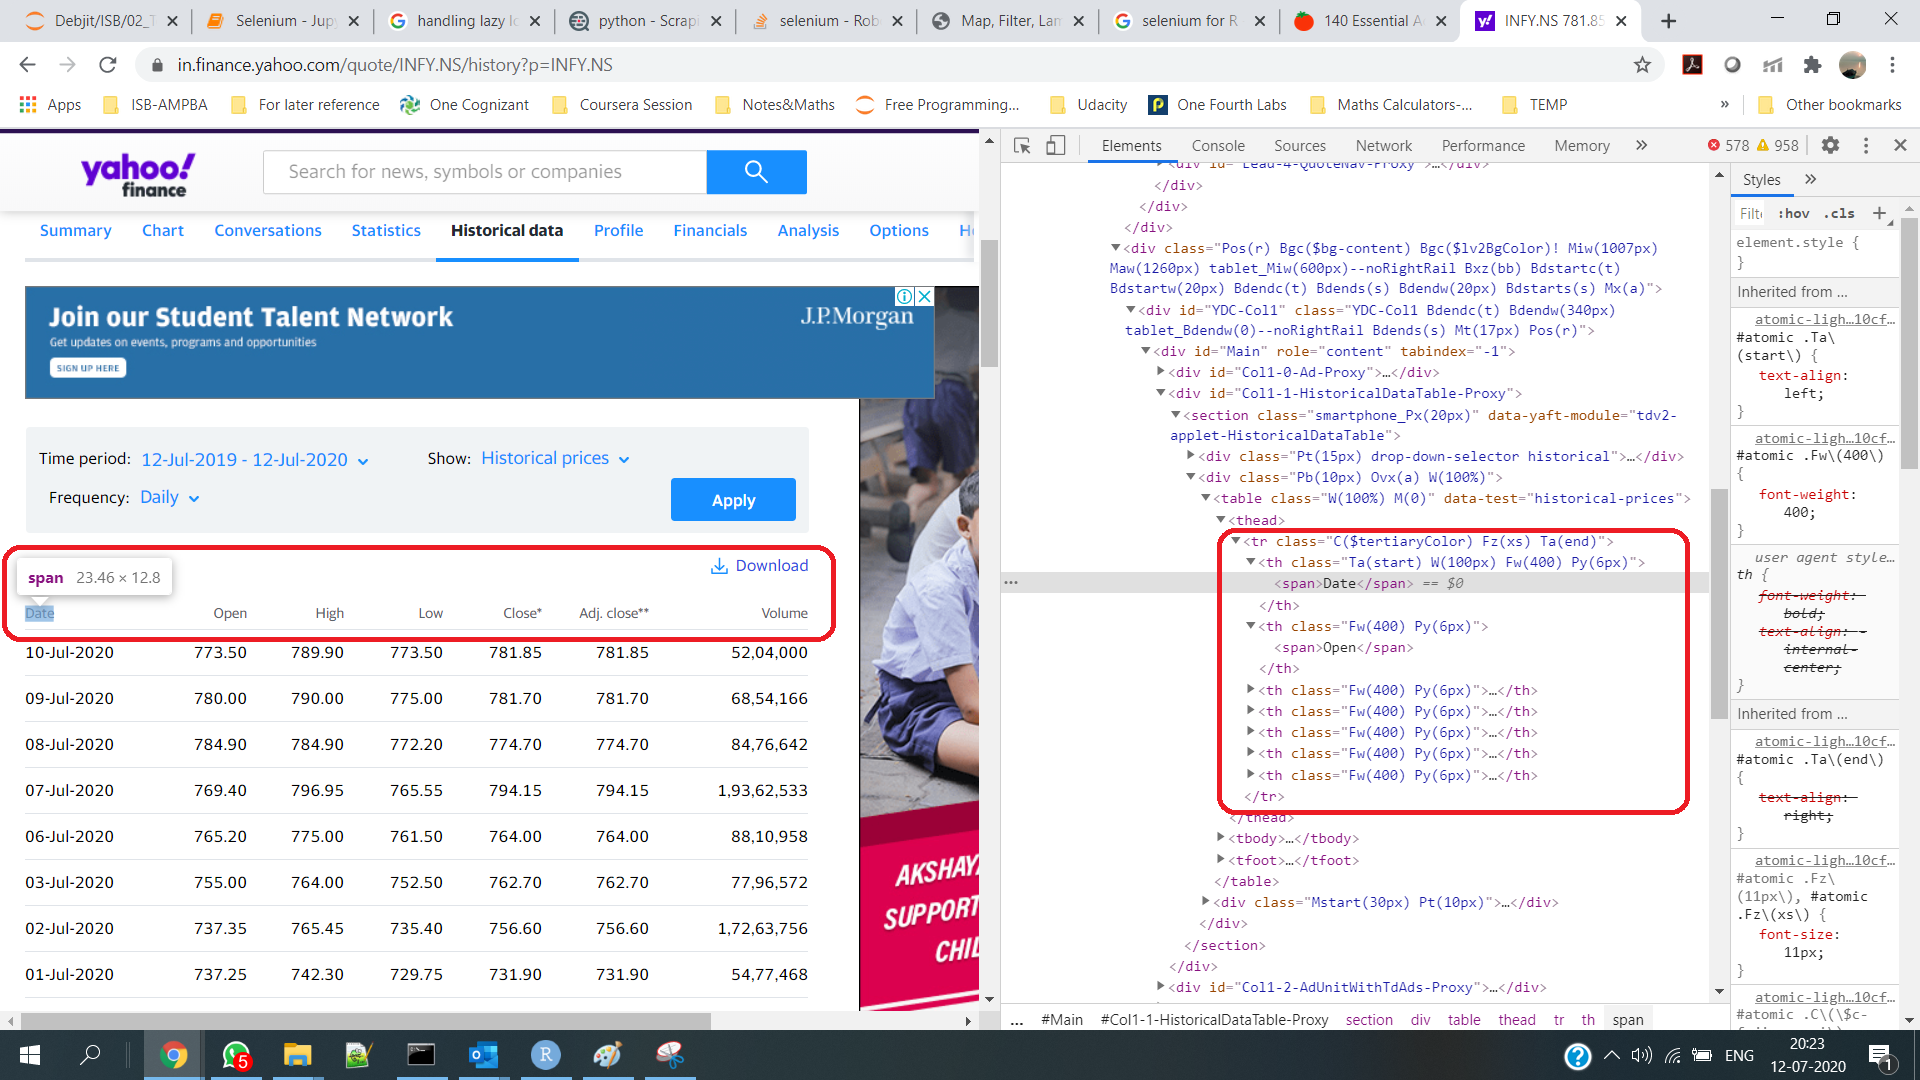

###### Finally, we will be scraping the table entries for the price details for each date. However, we will also be scraping the corporate actions like Dividend and Stock Splits in the table. Hence, we will require a logic to filter these rows.

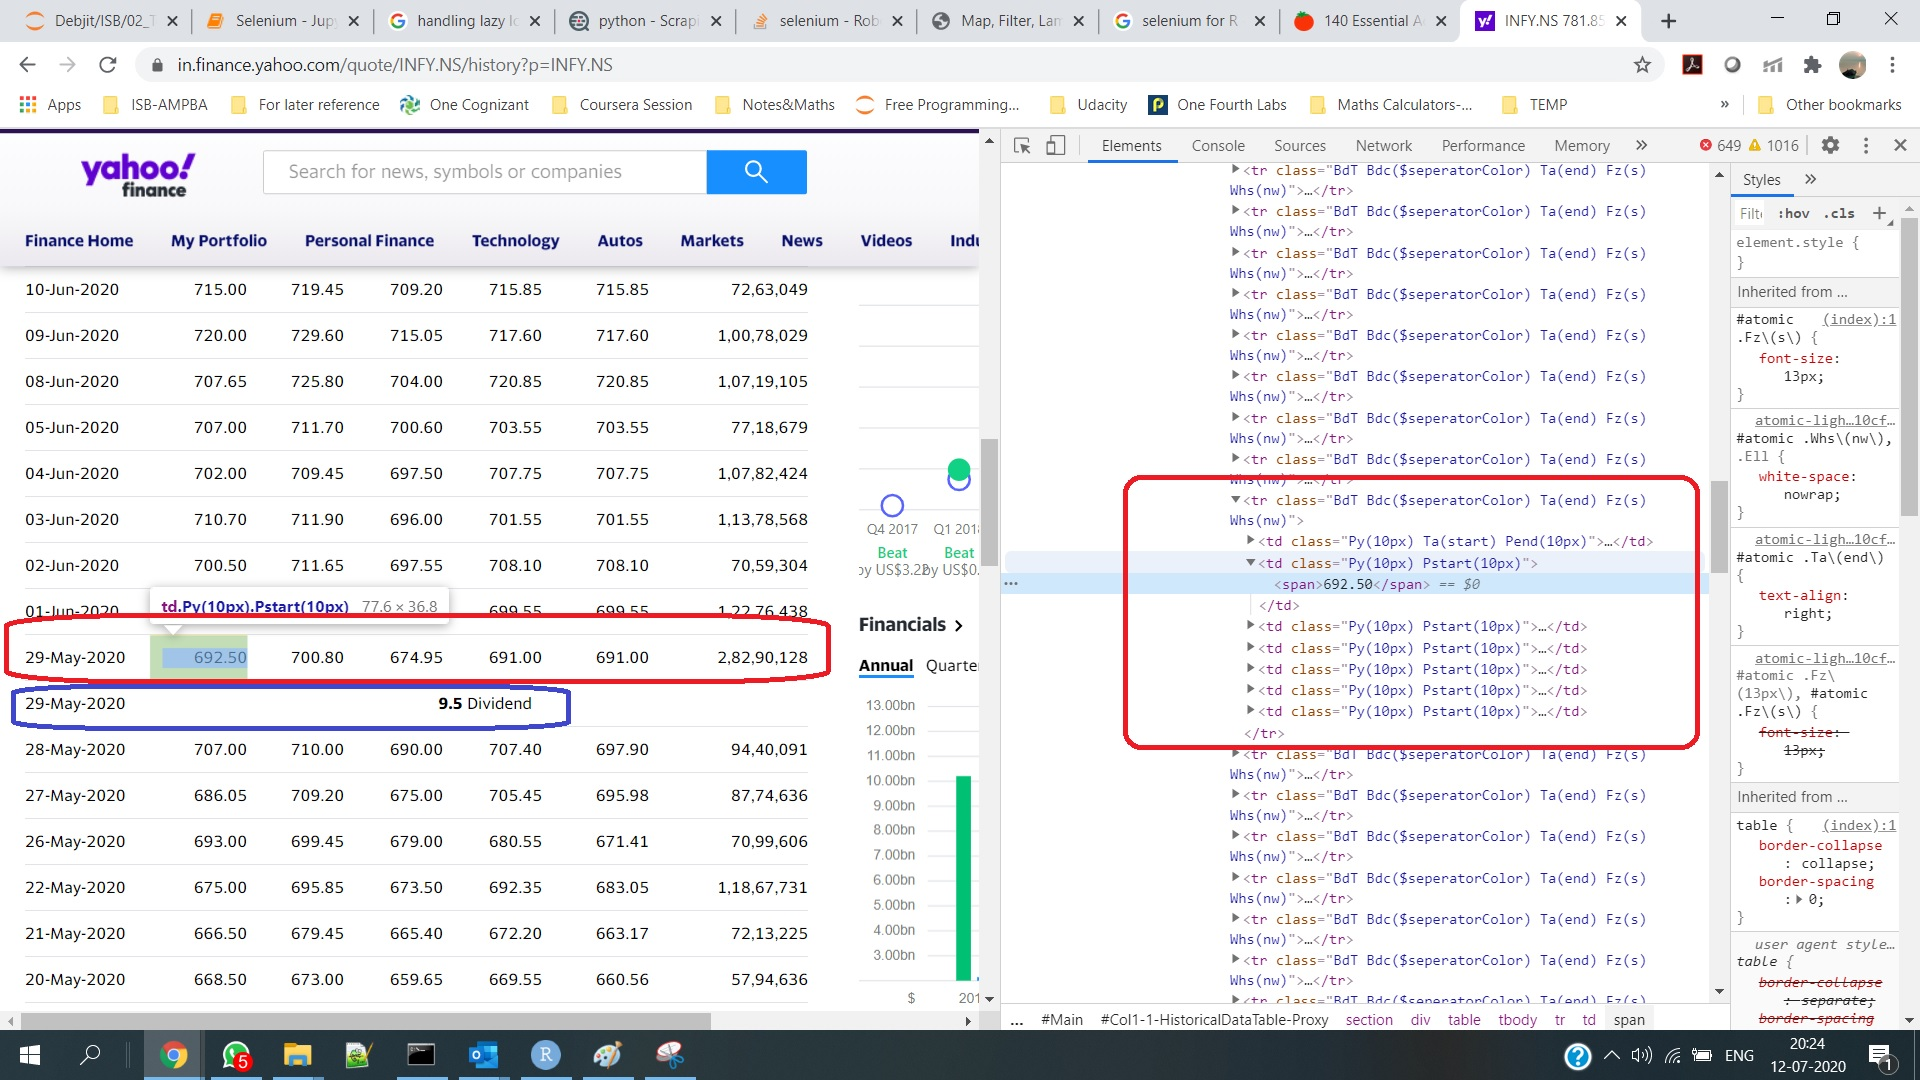

In [7]:
class stock_data():
    
    def webScrape(self, stock, exchange, startDate, endDate):
        print('INFO!! Extracting historical stock prices for ' + stock)
        stockHistoryURL = utility.getStockURL(stock, exchange, startDate, endDate)
        driver = utility.get_driver(webdriver)
        driver.get(stockHistoryURL)

        # Get the current number of rows
        current_rows_number = len(driver.find_elements_by_xpath('//tr'))
        while True:
            time.sleep(random.randint(5,15))
            # Scroll down to make new XHR (request more table rows)
            driver.find_element_by_tag_name('body').send_keys(Keys.END)
            try:
                # Wait until number of rows increased       
                wait(driver, 5).until(lambda driver: True if len(driver.find_elements_by_xpath('//tr')) > current_rows_number else False)
                # Update variable with current rows number
                current_rows_number = len(driver.find_elements_by_xpath('//tr'))
            # If number of rows remains the same after 5 seconds passed, break the loop
            # as there no more rows to receive
            except TimeoutException:
                break

        # Identify the stock name
        stockName = driver.find_element_by_xpath('//h1').text
        # Identify the table header and format to remove the '*' and space between 'Adj. close'
        colHdrs = driver.find_element_by_xpath('//tr').text
        colHdrs = colHdrs.replace('*', '')
        colHdrs = colHdrs.replace('. ', '.')
        colNames = colHdrs.split(' ')
        noOfCols = len(colNames)

        # Identify all the rows with the data
        trows = [element.text.split(' ') for element in driver.find_elements_by_xpath('//tr')]

        # We are done with the scraping. So close the driver.
        driver.quit()

        # The table has also picked up rows for corporate actions like (Dividend and Stock Splits). So, let us remove them.
        trows = [trow for trow in trows if len(trow) == noOfCols]

        # Convert the data to a Pandas dataframe
        DF = pd.DataFrame(trows, columns=colNames)
        DF['stockName'] = stockName
        DF = DF[1:]

        return self.cleanseDF(DF)
    
    @staticmethod
    def cleanseDF(DF):
        # On 27th Oct 2019 due to Diwali, there was a Mahurat trading of 1 hour. No data has been recorded for this date
        # Hence, eliminating these rows.
        DF = DF.loc[DF['Open'] != '-'].copy()

        # Function to remove commas and convert to Float. Will be used for Prices
        removeCommasFloat = lambda x: float(str(x).replace(",","")) if str(x).isnumeric() else x
        # Function to remove commas and convert to Int. Will be used for Volumes
        removeCommasInt = lambda x: int(str(x).replace(",","")) if str(x).isnumeric() else x

        # Apply the cleansing
        DF['Open'] = DF['Open'].apply(removeCommasFloat)
        DF['High'] = DF['High'].apply(removeCommasFloat)
        DF['Low'] = DF['Low'].apply(removeCommasFloat)
        DF['Close'] = DF['Close'].apply(removeCommasFloat)
        DF['Adj.close'] = DF['Adj.close'].apply(removeCommasFloat)
        DF['Volume'] = DF['Volume'].apply(removeCommasInt)

        return DF

#### Class to extract list of Organizations/ Companies based on the sector name passed as input
                                                

##### Method Used - BeautifulSoup screen scraping 

###### First, we need to extract the valid list of industries in an exchange (NSE). We do so by hitting the corresponding moneycontrol.com URL and extracting the industry list displayed below to a local csv file.

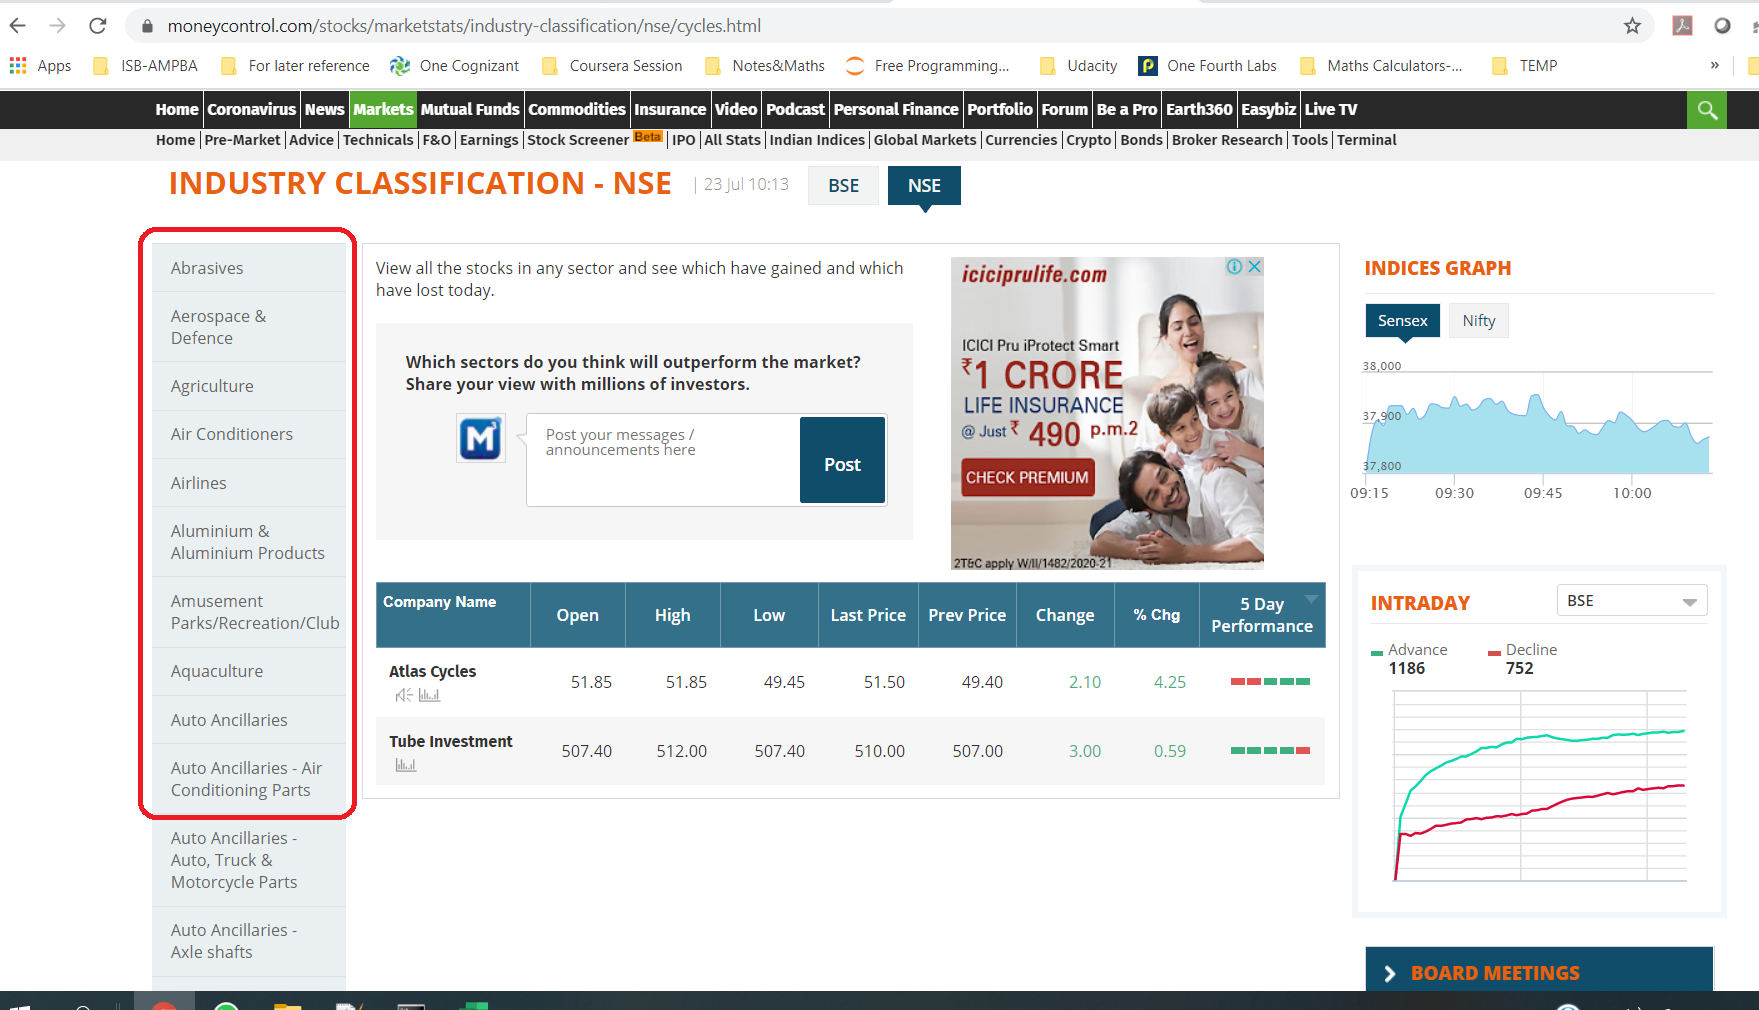

###### Next on the basis of a chosen industry, we identify the corresponding url from the csv file. The search here is a partial search. Hence, if there are multiple industries matching to the input text. All will be considered.

###### On the basis of the URL's specific to the industries, we hit the corresponding URL and extract the list of stocks.

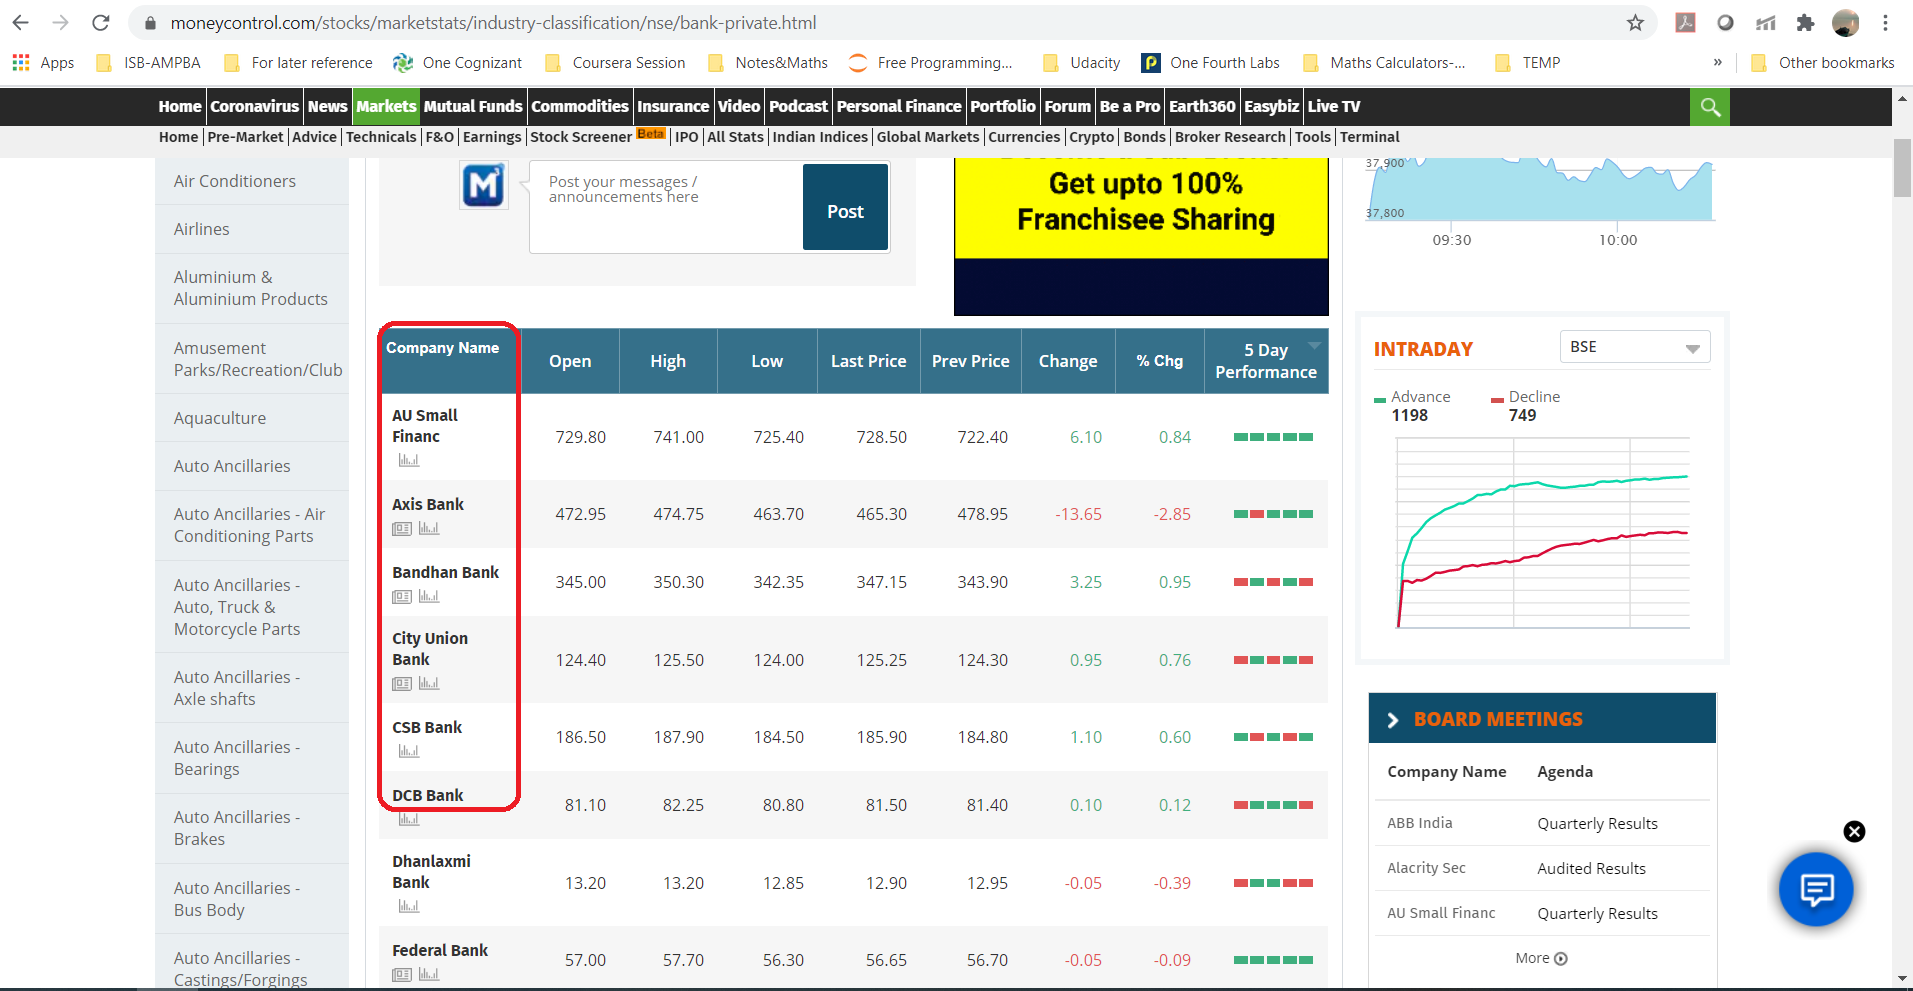

In [8]:
class sectorData():
    @staticmethod
    def getValidSectors(exchangeName):
        # Use a baseURL to hit the page and scrape the contents
        baseURL = urls.moneyControlBase.value + exchangeName + "/cycles.html"
        pageContent = requests.get(baseURL)
        # Validate the response code
        if pageContent.status_code == 200:
            soupObj = (BeautifulSoup(pageContent.text, 'lxml'))
            if soupObj != "":
                # Find the class and then the anchor ('a') tags
                sectorList = soupObj.find(class_ = "stat_lflist").find_all("a")
                # Using the anchor tags, extract the sector name
                sectorNames = [sectorOccurence.text for sectorOccurence in sectorList]
                # Using the anchor tags, extract the corresponding link for the sector
                sectorLinks = [sectorOccurence.get("href") for sectorOccurence in sectorList]
                # Convert the data to a DataFrame
                outDF = pd.DataFrame({"sector": sectorNames, "URL": sectorLinks})
                # For the page we hit to collect the details of URL's for all Sectors; the current page is marked as active.
                # Hence, we need to manually set the value.
                outDF.at[outDF['sector'] == 'Cycles', 'URL'] = "stocks/marketstats/sector-classification/" + exchangeName + "/cycles.html"
                # Store the URL with the complete address
                outDF['URL'] = urls.moneyControl.value + outDF['URL']
            return outDF
        else:
            print ("Unable to connect. Status Code: " + pageContent.status_code)
            return pd.DataFrame()
    
    @staticmethod
    def getStockNames(URLList):
        sectorList = list(URLList['sector'])
        URLs = list(URLList['URL'])
        allStockList = []
        for indx in range(0,len(URLList)):
            sectorName = sectorList[indx]
            sectorURL = URLs[indx]
            pageContent = requests.get(sectorURL)
            # Validate the response code
            if pageContent.status_code == 200:
                soupObj = (BeautifulSoup(pageContent.text, 'lxml'))
                if soupObj != "":
                    rowList = [stock.text for stock in soupObj.find_all("span", {"class":  "gld13"}, {"a"})]
                    stockList = [str(eachRow).split("\n")[0] for eachRow in rowList]
                    allStockList.append([sectorName, sectorURL, stockList])
        return allStockList
    
    def extractStockNames(self,exchange, inputSector):
        stockList = []
        # Check if the data is already extracted or not
        if (not os.path.exists('sector_URL_Index.csv')):
            print ("INFO!! File does not exist!! Fetching the sector details.")
            # Get the list of all different Sectors in NSE
            sectorDF = self.getValidSectors(exchange)
            # Write the data to a csv file to prevent fresh extraction 
            sectorDF.to_csv('sector_URL_Index.csv', index= False)
            #sectorDF.loc[:,['sector', 'URL']].to_csv('sector_URL_Index.csv', index= False)
        # If the data was already extracted last time, read from the csv file
        else:
            print ("INFO!! File exists!! Referring local file for sector details.")
            sectorDF = pd.read_csv('sector_URL_Index.csv')

        # Find all the indexes in the dataframe having a matching sector name as the input 
        URLList = sectorDF.loc[(pd.Series(sectorDF['sector']).str.findall(inputSector, flags = re.IGNORECASE).str.len() > 0)]
        
        if len(URLList) == 0:
            print ("ERROR!! No such sector found")
        else:
            stockList = self.getStockNames(URLList)
        return stockList

#### Class to create objects of different classes and utilize them to extract data from Twitter, newsapi, Indeed and YahooFinance 

In [9]:
class merge_data():
    
    def __init__(self):
        self.tweetsObj = fetch_tweets()
        self.stockObj = stock_data()
        self.empReviewObj = emp_review()
        self.newsBytesObj = news_bytes()
        
    def data_merger(self, org, exchange, startDate, endDate):
        
        tweets_df = self.tweetsObj.get_tweets(org)
        news_df = self.newsBytesObj.fetch_news(org, startDate, endDate)
        empReview_df = self.empReviewObj.fetch_emp_review(org)
        stocks_df = self.stockObj.webScrape(org, exchange, startDate, endDate)
        
        return (tweets_df,news_df, empReview_df, stocks_df)

### Main module to drive the entire program

In [10]:
if __name__ == '__main__':
    
    # Define all constants
    noOfYears = 1 # How long back into the history should we go for collecting historical stock prices
    # Based on the above period identify the start date and end date, which will be used to extract historical stock prices
    currentDate = datetime.date.today() 
    endDate = str(int(datetime.datetime(currentDate.year, currentDate.month, currentDate.day, 0, 0).timestamp()))
    startDate = str(int(datetime.datetime(currentDate.year - noOfYears, currentDate.month, currentDate.day, 0, 0).timestamp()))

    # Define the stock exchange which will be used to identify the stocks and extract data
    exchange = 'NSI' 
    exchangeName = 'nse'

    # Define the sector, from which we are going to extract the stock details
    sector = 'technology'

    sectorObj = sectorData()
    orgList = sectorObj.extractStockNames(exchangeName, sector)
    # At times, the page referred does not list stocks. In such cases, let us go ahead with a pre-determined set of companies 
    if (orgList == []):
        orgList = [['technology', 'dummy',['Infosys', 'Tata Consultancy Services Limited', 'Tech Mahindra Limited']]]


    # Declaring the dataframes to hold the result set
    tweets = pd.DataFrame()
    news = pd.DataFrame()
    empReview = pd.DataFrame()
    stocks = pd.DataFrame()

    # If a particular sector has multiple stocks listed, we do not want to collate the data for all the stocks. 
    # Hence, keeping it restricted to 3 stocks at a time
    orgCount = 0
    for eachOrg in orgList[0][2]:
        print ("\n\nINFO!! Extracting data for: " + eachOrg)
        
        # Define the object for the main class
        obj = merge_data()
        (tweets_DF, news_df, empReview_df, stocks_df) = (obj.data_merger(eachOrg, exchange, startDate, endDate))

        # Append the data extracted for one organization to a common dataframe/
        tweets = tweets.append(tweets_DF, ignore_index = True)
        news = news.append(news_df, ignore_index = True)
        empReview = empReview.append(empReview_df, ignore_index = True)
        stocks = stocks.append(stocks_df, ignore_index = True)    
        
        obj = None
        orgCount +=1
        if orgCount >= 3:
            break
            
    print ("INFO!! All extraction completed")

INFO!! File exists!! Referring local file for sector details.


INFO!! Extracting data for: InfoBeans Tech
INFO!! Extracting tweets for InfoBeans Tech
INFO!! Extracting news for InfoBeans Tech
INFO!! Web site does not exist for InfoBeans Tech. URL tried - https://www.indeed.co.in/cmp/InfoBeans%20Tech/reviews
INFO!! Extracting historical stock prices for InfoBeans Tech


INFO!! Extracting data for: Zensar Tech
INFO!! Extracting tweets for Zensar Tech
INFO!! Extracting news for Zensar Tech
INFO!! Extracting employee reviews for Zensar Tech
INFO!! Extracting historical stock prices for Zensar Tech


INFO!! Extracting data for: EuroMult
INFO!! Extracting tweets for EuroMult
INFO!! Extracting news for EuroMult
INFO!! Web site does not exist for EuroMult. URL tried - https://www.indeed.co.in/cmp/EuroMult/reviews
INFO!! Extracting historical stock prices for EuroMult
INFO!! All extraction completed


### Sample Output dataframes

In [11]:
tweets.head()

DateTime                                               Text  \
0  2020/07/25.17:00:00  Psst psst...Come close, we’ve got something fo...   
1  2020/01/29.22:34:16                               It's #infobeans tech   
2  2018/02/28.23:32:07  #ServiceNow - From Automating #IT to Complete ...   
3  2018/02/28.23:00:32  Why #Security and #Usability Are the Two Most ...   
4  2018/02/28.21:44:01  #SMEs and #SDS (Software-Defined Storage) - A ...   

   NoofLikes  NoofRetweets  NoofReplies  
0       2791          1217           17  
1          0             0            0  
2          0             0            0  
3          0             0            0  
4          0             0            0

In [12]:
news.head()

source            author  \
0        Moneycontrol              None   
1  The Times of India       Dil Prakash   
2  The Times of India      Anupam Nagar   
3     Theregister.com     Team Register   
4  The Times of India  Priyanka Sangani   

                                               title  \
0  InfoBeans Tech Standalone June 2020 Net Sales ...   
1          टेक महिंद्रा, NBCC में कमाई का अच्छा मौका   
2  Ahead of Market: 12 things that will decide st...   
3  Grappling with mixed infra, container security...   
4           Cloud services driving growth for Zensar   

                                         description  \
0                                               NULL   
1  सप्ताह के दूसरे दिन मंगलवार को सूचना प्रौद्योग...   
2  Here’s a look at what some of the key indicato...   
3  Grab your virtual tickets now for Continuous L...   
4  Cloud services driving growth for ZensarCompan...   

                                                 url  \
0  https://www.moneycontrol.com/news/business/ear...   
1  https://navbharattimes.indiatimes.com/business...   
2  https://economictimes.indiatimes.com/markets/s...   
3  https://www.theregister.com/2020/07/07/continu...   
4  https://economictimes.indiatimes.com/tech/ites...   

                                          urlToImage           publishedAt  \
0  https://images.moneycontrol.com/static-mcnews/...  2020-07-30T05:55:54Z   
1  https://navbharattimes.indiatimes.com/thumb/ms...  2020-07-28T00:00:00Z   
2  https://img.etimg.com/thumb/msid-77203451,widt...  2020-07-27T15:36:14Z   
3  https://regmedia.co.uk/2020/06/19/cll_online_h...  2020-07-07T14:00:12Z   
4  https://img.etimg.com/thumb/msid-77144727,widt...  2020-07-24T08:58:35Z   

                                             content  
0  Reported Standalone quarterly numbers for Info...  
1  , 2020 1.4 972.3 2018-19 959.3 - 5.2 9,106 8,6...  
2  NEW DELHI: Nifty closed below the 11,150 level...  
3  Event Depending on where you are, life is slow...  
4  PUNE: Mid-size IT services firm Zensar said th...

In [13]:
stocks.head()

Date   Open   High    Low  Close Adj.close    Volume  \
0  28-Jul-2020  91.80  99.80  88.15  99.80     99.80  2,22,925   
1  27-Jul-2020  91.60  91.60  88.95  90.75     90.75     8,183   
2  24-Jul-2020  91.80  91.80  88.95  89.25     89.25     8,453   
3  23-Jul-2020  91.35  92.10  89.35  90.55     90.55     7,414   
4  22-Jul-2020  93.45  93.45  90.00  91.35     91.35     8,752   

                                      stockName  
0  InfoBeans Technologies Limited (INFOBEAN.NS)  
1  InfoBeans Technologies Limited (INFOBEAN.NS)  
2  InfoBeans Technologies Limited (INFOBEAN.NS)  
3  InfoBeans Technologies Limited (INFOBEAN.NS)  
4  InfoBeans Technologies Limited (INFOBEAN.NS)

In [14]:
empReview.head()

Company              Designation  \
0  https://www.indeed.co.in/cmp/Zensar%20Tech/rev...                      SSE   
1  https://www.indeed.co.in/cmp/Zensar%20Tech/rev...  Senior Systems Engineer   
2  https://www.indeed.co.in/cmp/Zensar%20Tech/rev...            Data Engineer   
3  https://www.indeed.co.in/cmp/Zensar%20Tech/rev...        Software Engineer   
4  https://www.indeed.co.in/cmp/Zensar%20Tech/rev...     Full Stack Developer   

  Rating               Customer_review       Pros Cons  
0    1.0            Do not Join Zensar                  
1    2.0                 Collaborative  Team work       
2    5.0                  Nice company                  
3    4.0  Good place to learn and grow                  
4    4.0                          Good